In [ ]:
import numpy as np
import pandas_datareader as web
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
from matplotlib.pyplot import figure
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [ ]:
df = web.DataReader("PETR4.SA", data_source="yahoo", start="2015-01-01", end="2019-12-31")
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-01-02,9.990000,9.350000,9.990000,9.36,49559500.0,8.400862
2015-01-05,9.190000,8.530000,9.140000,8.56,78385100.0,7.682839
2015-01-06,8.830000,8.040000,8.710000,8.28,84723300.0,7.431530
2015-01-07,8.730000,8.360000,8.560000,8.67,85531000.0,7.781567
2015-01-08,9.390000,8.740000,8.790000,9.23,83306300.0,8.284181
...,...,...,...,...,...,...
2019-12-20,30.600000,30.020000,30.600000,30.26,93064900.0,28.873985
2019-12-23,30.500000,30.030001,30.190001,30.50,21970200.0,29.102993
2019-12-26,30.930000,30.500000,30.590000,30.91,24810500.0,29.494211


In [ ]:
df.shape

(1241, 6)

In [ ]:
df_bovespa = web.DataReader("^BVSP", data_source="yahoo", start="2015-01-01", end="2019-12-31")
# df_bovespa.reset_index(inplace=True,drop=False)
df_bovespa

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-01-02,50005.0,48345.0,50005.0,48512.0,2882100.0,48512.0
2015-01-05,48512.0,47264.0,48512.0,47517.0,3866100.0,47517.0
2015-01-06,48061.0,47338.0,47517.0,48001.0,4559300.0,48001.0
2015-01-07,49882.0,48006.0,48006.0,49463.0,4408800.0,49463.0
2015-01-08,50261.0,49017.0,49463.0,49943.0,3621900.0,49943.0
...,...,...,...,...,...,...
2019-12-20,115171.0,114526.0,115133.0,115121.0,6887400.0,115121.0
2019-12-23,115863.0,114964.0,115119.0,115863.0,3995200.0,115863.0
2019-12-26,117220.0,115673.0,115864.0,117203.0,3788900.0,117203.0


In [ ]:
df_bovespa.shape

(1235, 6)

In [ ]:
df = df.merge(df_bovespa, left_on='Date', right_on='Date', suffixes=('', '_bovespa'))
df.describe()

,High,Low,Open,Close,Volume,Adj Close,High_bovespa,Low_bovespa,Open_bovespa,Close_bovespa,Volume_bovespa,Adj Close_bovespa
count,1235.000000,1235.000000,1235.000000,1235.000000,1.235000e+03,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1.235000e+03,1235.000000
mean,16.946024,16.417725,16.693765,16.669887,5.410856e+07,15.220927,71258.726316,69996.229960,70605.106883,70656.285020,3.794215e+06,70656.285020
std,7.135614,7.025846,7.087856,7.081970,2.619016e+07,6.751748,19634.810008,19447.130086,19532.433000,19564.626768,1.203582e+06,19564.626768
min,4.270000,4.120000,4.200000,4.200000,0.000000e+00,3.769617,38031.000000,37046.000000,37501.000000,37497.000000,0.000000e+00,37497.000000
25%,11.150000,10.630000,10.910000,10.855000,3.727595e+07,9.742666,53498.500000,52677.000000,53087.500000,53094.500000,3.078600e+06,53094.500000
50%,15.520000,15.060000,15.300000,15.310000,4.868110e+07,13.741150,66758.000000,65842.000000,66195.000000,66235.000000,3.658900e+06,66235.000000
75%,23.160000,22.575000,22.810000,22.890000,6.523980e+07,20.658709,86157.000000,84582.500000,85515.000000,85539.000000,4.389100e+06,85539.000000
max,31.230000,30.500000,30.889999,30.969999,2.403438e+08,29.551464,117803.000000,115995.000000,117205.000000,117203.000000,1.104670e+07,117203.000000


In [ ]:
data = df.filter(["Close", "Volume", "Close_bovespa", "Volume_bovespa"])
dataset = data.values
training_data_len = math.ceil(len(dataset) * .7)
training_data_len
dataset.shape

(1235, 4)

In [ ]:
sc = MinMaxScaler(feature_range = (0, 1))
scaled_data = sc.fit_transform(dataset)

In [ ]:
scaled_data

array([[0.19275308, 0.20620253, 0.13819537, 0.26090145],
       [0.16286891, 0.32613739, 0.12571199, 0.34997782],
       [0.15240941, 0.35250878, 0.13178431, 0.41272959],
       ...,
       [0.99775871, 0.10322921, 1.        , 0.34298931],
       [0.98319018, 0.10399727, 0.99160665, 0.35358071],
       [0.97048939, 0.09199988, 0.98445537, 0.33203581]])

In [ ]:
train_data = scaled_data[0:training_data_len,:]
# print(train_data)
window = 60
X_train = []
y_train = []
for i in range(window, len(train_data)):
    X_train.append(train_data[i-window:i,:])
    y_train.append(train_data[i, 0:1])
    # if i <= (window + 1):
    #   print(X_train)
    #   print(y_train)
    #   print()
X_train, y_train = np.array(X_train), np.array(y_train)

In [ ]:
X_train.shape

(805, 60, 4)

In [ ]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], -1))

In [ ]:
X_train.shape

(805, 60, 4)

In [ ]:
# Inicializar a RNN
regressor = Sequential()

# Adicionar a primeira camada LSTM e Dropout 
regressor.add(LSTM(units = 100, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
regressor.add(Dropout(0.2))
 
# Adicionar a segunda camada LSTM e Dropout
regressor.add(LSTM(units = 80, return_sequences = True))
regressor.add(Dropout(0.2))
 
# Adicionar a terceira camada LSTM e Dropout
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))
 
# camada de saída
regressor.add(Dense(units = 1))
 
# Compilar a rede
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Visualizar a rede
regressor.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 60, 100)           42000     
_________________________________________________________________
dropout_3 (Dropout)          (None, 60, 100)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 60, 80)            57920     
_________________________________________________________________
dropout_4 (Dropout)          (None, 60, 80)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 50)                26200     
_________________________________________________________________
dropout_5 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

In [ ]:
history = regressor.fit(X_train, y_train, epochs = 50, batch_size = 64)

Epoch 1/50
13/13 [==============================] - 7s 156ms/step - loss: 0.0580
Epoch 2/50
13/13 [==============================] - 2s 155ms/step - loss: 0.0064
Epoch 3/50
13/13 [==============================] - 2s 154ms/step - loss: 0.0041
Epoch 4/50
13/13 [==============================] - 2s 155ms/step - loss: 0.0034
Epoch 5/50
13/13 [==============================] - 2s 156ms/step - loss: 0.0038
Epoch 6/50
13/13 [==============================] - 2s 153ms/step - loss: 0.0033
Epoch 7/50
13/13 [==============================] - 2s 155ms/step - loss: 0.0031
Epoch 8/50
13/13 [==============================] - 2s 160ms/step - loss: 0.0031
Epoch 9/50
13/13 [==============================] - 2s 155ms/step - loss: 0.0029
Epoch 10/50
13/13 [==============================] - 2s 155ms/step - loss: 0.0026
Epoch 11/50
13/13 [==============================] - 2s 155ms/step - loss: 0.0034
Epoch 12/50
13/13 [==============================] - 2s 154ms/step - loss: 0.0028
Epoch 13/50
13/13 [======

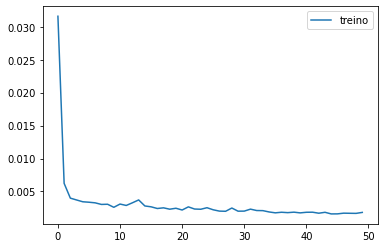

In [ ]:
plt.plot(history.history['loss'], label='treino')
plt.legend();

In [ ]:
test_data = scaled_data[training_data_len - window:, :]

X_test = []
y_test = dataset[training_data_len:, 0:1]

for i in range(window, len(test_data)): 
    X_test.append(test_data[i-window:i,:])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], -1))
print(X_test.shape, X_train.shape)

(370, 60, 4) (805, 60, 4)


In [ ]:
predicted = regressor.predict(X_test)
volume = dataset[training_data_len:, 1:]
predicted = np.column_stack((predicted, volume))
# print(dataset[:,1:])
print(predicted.shape)
predicted = sc.inverse_transform(predicted)
print(predicted)

(370, 4)
[[1.67755769e+01 1.82024617e+16 5.79968518e+09 4.28545680e+13]
 [1.70321488e+01 1.31096968e+16 5.80582254e+09 3.04215071e+13]
 [1.73258268e+01 1.38093616e+16 5.87181911e+09 3.59437525e+13]
 ...
 [2.83960883e+01 5.96304985e+15 9.34181982e+09 4.18548416e+13]
 [2.84896393e+01 6.00741732e+15 9.28849650e+09 4.31473055e+13]
 [2.86822908e+01 5.31438597e+15 9.24306408e+09 4.05181909e+13]]


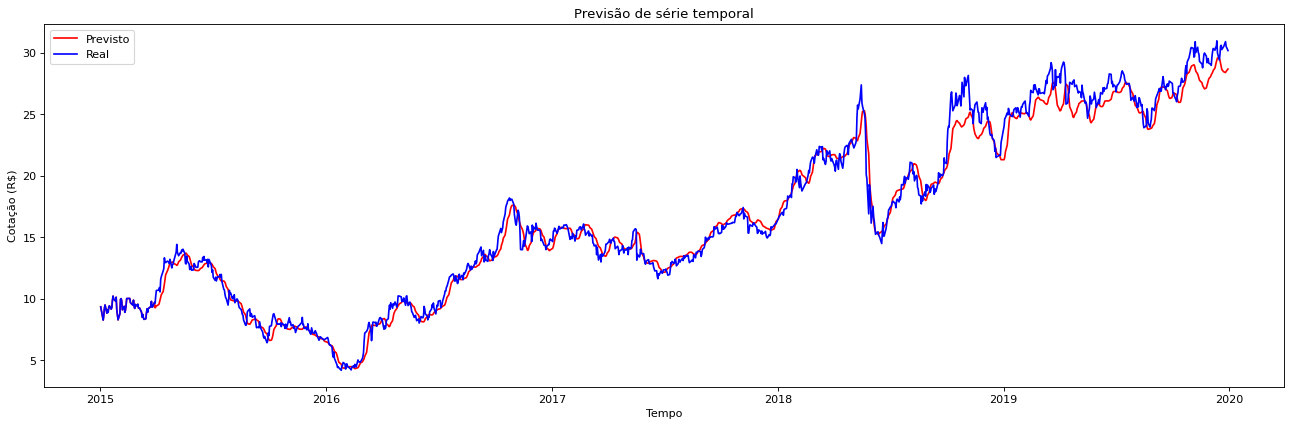

In [ ]:
allTargetData = np.vstack((dataset[:training_data_len, 0:1], dataset[training_data_len:, 0:1]))
training_predicted = regressor.predict(X_train)
volume = dataset[:len(X_train), 1:]
training_predicted = np.column_stack((training_predicted, volume))
training_predicted = sc.inverse_transform(training_predicted)
allForecastedData = np.vstack((dataset[0:window, 0:1], training_predicted[:,0:1], predicted[:,0:1]))
# date = df['DATA']
date = df.index

figure(figsize=(20, 6), dpi=80)
plt.plot(date, allForecastedData, color = 'red', label = 'Previsto')
plt.plot(date, allTargetData, color = 'blue', label = 'Real')
plt.title('Previsão de série temporal')
plt.xlabel('Tempo')
plt.ylabel('Cotação (R$)')
plt.legend()
plt.show()

In [ ]:
rmse = math.sqrt(mean_squared_error(dataset[training_data_len:, 0:1], predicted[:,0:1]))
print('RMSE: ', rmse)

RMSE:  1.3884172406891426


In [ ]:
mse = mean_squared_error(dataset[training_data_len:, 0:1], predicted[:,0:1])
print('MSE: ',mse)

MSE:  1.9277024342428526


In [ ]:
mape = np.mean(np.abs((dataset[training_data_len:, 0:1]-predicted[:,0:1]) /dataset[training_data_len:, 0:1])) * 100
print('MAPE: ',mape, '%')

MAPE:  4.181302215289487 %


In [ ]:
print('R2: ', r2_score(predicted[:,0:1], dataset[training_data_len:, 0:1]))

R2:  0.7786037816945297


In [ ]:
scaled_data = scaled_data
window = 60
X_data = []
y_data = []
for i in range(window, len(scaled_data)):
    X_data.append(scaled_data[i-window:i,:])
    y_data.append(scaled_data[i, 0:1])
X_data, y_data = np.array(X_data), np.array(y_data)
history = regressor.fit(X_data, y_data, epochs = 50, batch_size = 64)

In [ ]:
predicted = regressor.predict(X_data)
print(predicted)
volume = dataset[:len(X_data), 1:]
predicted = np.column_stack((predicted, volume))
predicted = sc.inverse_transform(predicted)
allForecastedData = predicted[:,0:1]
# date = df['DATA']
date = df.index
print(dataset.shape)
print(predicted.shape)
figure(figsize=(20, 6), dpi=80)
plt.plot(dataset[window:, 0:1], color = 'red', label = 'Previsto')
plt.plot(predicted[:,0:1], color = 'blue', label = 'Real')
plt.title('Previsão de série temporal')
plt.xlabel('Tempo')
plt.ylabel('Cotação (R$)')
plt.legend()
plt.show()

In [ ]:
from datetime import date, datetime, timedelta
today = datetime.today()
today_minus_100 = today - timedelta(days=100)
df_new = web.DataReader("PETR4.SA", data_source="yahoo", start=today_minus_100, end=today)
df_bovespa_new = web.DataReader("^BVSP", data_source="yahoo", start=today_minus_100, end=today)
df_dolar_new = web.DataReader("USDBRL=X", data_source="yahoo", start=today_minus_100, end=today)
df_new = df_new.merge(df_bovespa_new, left_on='Date', right_on='Date', suffixes=('', '_bovespa'))
df_new = df_new.merge(df_dolar_new, left_on='Date', right_on='Date', suffixes=('', '_dolar'))
df_new = df_new.filter(["Close", "Volume", "Close_bovespa", "Volume_bovespa"])

print(df_new.tail())
last_days = df_new.values
scaled = sc.transform(last_days)
x = []
x.append(scaled)
x = np.array(x)
x = np.reshape(x, (x.shape[0], x.shape[1], -1))
pred_price = regressor.predict(x)
volume_new = last_days[0:1, 1:]
pred_price = np.column_stack((pred_price, volume_new))
pred_price = sc.inverse_transform(pred_price)
print(pred_price[0][0])